In [1]:
import tensorflow as tf
import numpy as np

In [2]:
vgg = tf.keras.applications.VGG19()
vgg.summary()

W1130 00:22:55.579964 11372 deprecation.py:506] From C:\Users\Gencho\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
#input_tensor = tf.keras.Input(shape = (224, 224, 3))
vgg = tf.keras.applications.VGG19(weights ='imagenet')
#vgg = tf.keras.applications.VGG19()

vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
labels_count = 20
grid_size = 7
boxes_per_grid_cell = 2

In [5]:
layers = vgg.layers[:-1]
object_detection_predictions_layer = tf.keras.layers.Dense(units = grid_size * grid_size * (5 * boxes_per_grid_cell + labels_count))

layers.append(object_detection_predictions_layer)
#layers.append(tf.keras.layers.Reshape(target_shape=(grid_size, grid_size, (5 * boxes_per_grid_cell + labels_count))))

model = tf.keras.Sequential(layers, "object detector")
model.summary()

Model: "object detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)   

In [6]:
Lcoord = 5
Lnoobj = 0.5

In [7]:
def custom_loss(y_true, y_pred):
    '''
    output tensor:
    
    for each cell:
        for each bounding box:
            x, y, w, h, C(any)
        for each class:
            C(class)
    
    flattened
    '''

    
    #TODO: translate every operation to tensorflow?
    
    loss = tf.constant(0.0)
    
    step_size = 5 * boxes_per_grid_cell + labels_count
    
    def get_true_pred(index):
        return y_true[:, index], y_pred[:, index]
    
    for cell in range(grid_size ** 2):
        index = cell * step_size # 0
        
        '''
        TODO:
        At training time we only want one bounding box predictor to be responsible for each object. 
        We assign one predictor to be “responsible” for predicting an object based on which 
        prediction has the highest current IOU with the ground truth.
        We optimise the x,y,w,h,c of that box with Lcoord factor and just c of the others with Lnoobj factor        
        For ci we optimise for every box
        
        TODO:
        Rearrange tensor shapes (first w, y, w, h, c for each box, then ci for each box)?
        Reshape to 3d tensor instead of linear per prediction?
        '''        
    
        for box in range(boxes_per_grid_cell):
            inner_step_size = box * 5
            
            
            xtrue, xpred = get_true_pred(inner_step_size + index)
            ytrue, ypred = get_true_pred(inner_step_size + index + 1)
            wtrue, wpred = get_true_pred(inner_step_size + index + 2)
            htrue, hpred = get_true_pred(inner_step_size + index + 3)
            Canytrue, Canypred = get_true_pred(inner_step_size + index + 4)
                                  
            
            loss = tf.add(loss, (Lnoobj if Canytrue == 0 else 1) * ((Canytrue - Canypred) ** 2)) 
            
            loss = tf.cond(tf.less(tf.reduce_mean(tf.subtract(1.0, Canytrue)), 0), lambda: tf.add(tf.add(loss, Lcoord * ((xtrue - xpred) ** 2 + (ytrue - ypred) ** 2)), Lcoord * ((tf.sqrt(wtrue) - tf.sqrt(wpred)) ** 2 + (tf.sqrt(htrue) - tf.sqrt(hpred)) ** 2)), lambda: loss)       
            #if Canytrue:
            #    loss += Lcoord * ((xtrue - xpred) ** 2 + (ytrue - ypred) ** 2)
            #    loss += Lcoord * ((sqrt(wtrue) - sqrt(wpred)) ** 2 + (sqrt(htrue) - sqrt(hpred)) ** 2)
        
        for label in range(labels_count):
            Clabeltrue, Clabelpred = get_true_pred(index + boxes_per_grid_cell * 5 + label)
            
            loss = tf.add(loss, (Lnoobj if Clabeltrue == 0 else 1) * ((Clabeltrue - Clabelpred) ** 2)) 
                
    return loss
    
    

In [8]:
adam = tf.keras.optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer = adam, loss = custom_loss)

In [9]:
import xml.etree.ElementTree as ET
import os

path = '.\VOCdevkit\VOC2007\Annotations'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.xml' in file:
            files.append(os.path.join(r, file))

files = files[:100]
            
eltrees = [ET.parse(file) for file in files]

allnames = []
uniques = set()

for names in [names for names in [xml.findall('object/name') for xml in eltrees]]:
    for name in names:
            allnames.append(name)
            uniques.add(name.text)

print(len(files))
print(len(allnames))
labels = [n for n in names]

print(uniques)
print(len(uniques))

100
278
{'tvmonitor', 'horse', 'bicycle', 'sofa', 'person', 'chair', 'bird', 'cat', 'pottedplant', 'car', 'dog', 'boat', 'cow', 'aeroplane', 'sheep', 'motorbike', 'bottle', 'bus', 'train', 'diningtable'}
20


In [10]:
def read_labels(path):    
    with open(path) as f:
        labels = f.readlines()
    
    labels = [l.strip() for l in labels] 
    labels_count = len(labels)
    
    return labels, labels_count

labels, labels_count = read_labels("labels.txt")
labels, labels_count

(['horse',
  'diningtable',
  'sofa',
  'train',
  'bird',
  'aeroplane',
  'person',
  'boat',
  'bottle',
  'motorbike',
  'bus',
  'cat',
  'pottedplant',
  'car',
  'dog',
  'bicycle',
  'sheep',
  'cow',
  'tvmonitor',
  'chair'],
 20)

In [11]:
class LabelEncoder():
    def __init__(self, labels):
        self.__dict__ = dict()
        
        index = 0
        for label in labels:
            self.__dict__[label] = index
            self.__dict__[index] = label
            index += 1
            
    def encode(self, label):
        return self.__dict__[label]
    
    def decode(self, index):
        return self.__dict__[index]
    
encoder = LabelEncoder(labels)

testlabel = labels[3]
print(testlabel)
print(encoder.encode(testlabel))
print(encoder.decode(encoder.encode(testlabel)))

train
3
train


In [12]:
class Hack(object):
    def __str__(self):
        return f'{self.name} ({self.xmin}, {self.ymin}) ({self.xmax}, {self.ymax})'

def parse_annotation(filepath):    
    objects = []
    
    et = ET.parse(filepath)
    for obj in et.findall('object'):
        curr = Hack()
        for child in obj.iter():
            if child.tag != 'bndbox':
                if(child.text.isdigit()):
                    setattr(curr, child.tag, int(child.text))
                else:
                    setattr(curr, child.tag, child.text)
        objects.append(curr)
        
    
    filename = et.find('filename').text
    width = et.find('size/width').text
    height = et.find('size/height').text
    
    result = Hack()
    setattr(result, 'objects', objects)
    setattr(result, 'imagewidth', int(width))
    setattr(result, 'imageheight', int(height))
    setattr(result, 'filename', filename)
    
    return result

testannotation = r'.\\VOCdevkit\\VOC2007\\Annotations\\000005.xml'

parsedannotation = parse_annotation(testannotation)

print(parsedannotation.filename)
print(parsedannotation.imagewidth)
print(parsedannotation.imageheight)
for obj in parsedannotation.objects:
    print(obj)

000005.jpg
500
375
chair (263, 211) (324, 339)
chair (165, 264) (253, 372)
chair (5, 244) (67, 374)
chair (241, 194) (295, 299)
chair (277, 186) (312, 220)


In [13]:
'''
notes:
    normalize bounding box width and height according to image width and height so that they fall between 0 and 1
    normalize x, y according to the box
'''

def get_expected_output_from_annotations(annotation_path):
    '''
    
    
    Each grid cell predicts B bounding boxes and confidence
    scores for those boxes. These confidence scores reflect how
    confident the model is that the box contains an object and
    also how accurate it thinks the box is that it predicts. Formally we define confidence as Pr(Object) ∗ IOUtruth
    pred . If no
    object exists in that cell, the confidence scores should be
    zero. Otherwise we want the confidence score to equal the
    intersection over union (IOU) between the predicted box
    and the ground truth.
    
    '''
    #TODO(maybe): Implement a confidence for each box instead of 0 -> IOU of the best box possible
    
    parsed = parse_annotation(annotation_path)
    
    expected = np.zeros(grid_size * grid_size * (5 * boxes_per_grid_cell + labels_count))
    
    rowstep = parsed.imageheight / grid_size
    colstep = parsed.imagewidth / grid_size
    
    grid = [[[] for i in range(grid_size)] for i in range(grid_size)]
    
    for obj in parsed.objects:
        obj.xmid = (obj.xmax + obj.xmin) / 2
        obj.ymid = (obj.ymax + obj.ymin) / 2
        obj.width = obj.xmax - obj.xmin
        obj.height = obj.ymax - obj.ymin
                
        row = int(obj.ymid / rowstep)
        col = int(obj.xmid / colstep)
        
        grid[row][col].append(obj)
    
    tensorindex = 0
    for row in range(grid_size):
        for col in range(grid_size):
            objects = grid[row][col]                     
            
            # calculate bounding boxes
            boxleftstart = col * colstep
            boxtopstart = row * rowstep
            
            for box in range(boxes_per_grid_cell):
                if len(objects) > box:
                    obj = objects[box]              
                                        
                    expected[tensorindex] = (obj.xmid - boxleftstart) / colstep # x regarding box left border scaled to box width
                    expected[tensorindex + 1] = (obj.ymid - boxtopstart) / rowstep # y regarding box top border scaled to box height              
                    expected[tensorindex + 2] = obj.width / parsed.imagewidth # width relative to image width
                    expected[tensorindex + 3] = obj.height / parsed.imageheight #height relative to image height
                    expected[tensorindex + 4] = 1 #confidence
                    
                tensorindex += 5
                
            # mark objects present in grid cell 
            # TODO: rework if there are more classes present than boxes
            #for obj in objects:
            #    expected[tensorindex + encoder.encode(obj.name)] = 1
            #tensorindex += labels_count               
    
    
    return expected

with np.printoptions(threshold=np.inf):
    print(get_expected_output_from_annotations(testannotation))
#get_expected_output_from_annotations(testannotation)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [14]:
def decode_predictions(output, image_w, image_h, threshold):
    objects = []
    
    rowstep = image_h / grid_size
    colstep = image_w / grid_size
    
    tensorindex = 0
    for row in range(grid_size):
        for col in range(grid_size):
            
            # calculate bounding boxes
            boxleftstart = col * colstep
            boxtopstart = row * rowstep            
            
            for box in range(boxes_per_grid_cell):
                xmid = (output[tensorindex] * colstep) + boxleftstart# x = (obj.xmid - boxleftstart) / colstep # x regarding box left border scaled to box width
                ymid = (output[tensorindex + 1] * rowstep) + boxtopstart# = (obj.ymid - boxtopstart) / rowstep # y regarding box top border scaled to box height              
                w = output[tensorindex + 2] * image_w# = obj.width / parsed.imagewidth # width relative to image width
                h = output[tensorindex + 3] * image_h# = obj.height / parsed.imageheight #height relative to image height
                c = output[tensorindex + 4]# = 1 #confidence

                if(c >= threshold):
                    obj = Hack()
                    obj.xmin = xmid - (w / 2)
                    obj.ymin = ymid - (h / 2)
                    obj.xmax = xmid + (w / 2)
                    obj.ymax = ymid + (h / 2)
                    obj.name = '' #TODO: decode class

                    objects.append(obj)                                              
                   
                    
                tensorindex += 5 
                
            tensorindex += labels_count    
            
            
    
    
    return objects

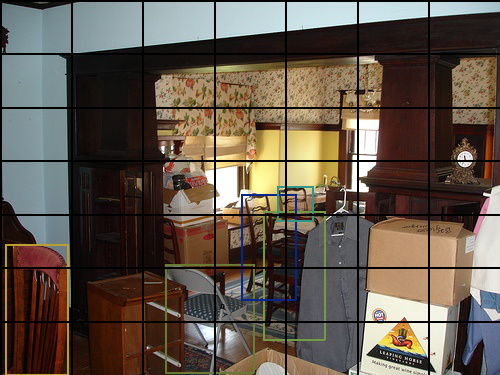

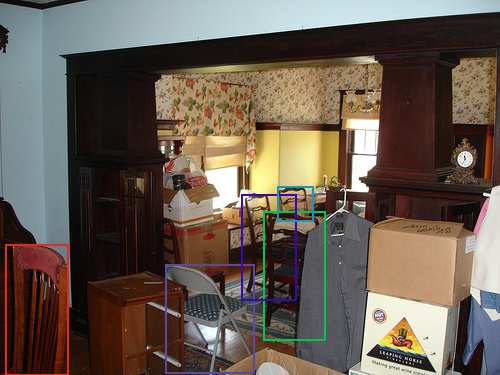

In [15]:
from IPython.core.display import Image, display
from PIL import Image as Img
from PIL import ImageDraw as ImgDraw
from random import uniform

testimage = r'.\\VOCdevkit\\VOC2007\\JPEGImages\\000005.jpg'

def get_color():
    return (int(uniform(0, 255)), int(uniform(0, 255)), int(uniform(0, 255)))

def draw_image(imagepath, objects = [], draw_grid = False):
    im = Img.open(imagepath)
    
    draw = ImgDraw.Draw(im)
    
    for obj in objects:
        color = get_color()
        
        draw.line((obj.xmin, obj.ymin) + (obj.xmax, obj.ymin), fill = color, width = 2)
        draw.line((obj.xmin, obj.ymax) + (obj.xmax, obj.ymax), fill = color, width = 2)
        draw.line((obj.xmin, obj.ymin) + (obj.xmin, obj.ymax), fill = color, width = 2)
        draw.line((obj.xmax, obj.ymin) + (obj.xmax, obj.ymax), fill = color, width = 2)
        
        
        #xmid = (obj.xmax + obj.xmin) / 2
        #ymid = (obj.ymax + obj.ymin) / 2
        #draw.line((xmid, ymid) + (xmid, ymid), fill = color, width = 2)
    
    if draw_grid:
        width_factor = im.width / grid_size
        height_factor = im.height / grid_size
        
        for i in range(grid_size):
            draw.line((i * width_factor, 0) + (i * width_factor, im.width), fill = 0, width = 2)
            draw.line((0, i * height_factor) + (im.width, i * height_factor), fill = 0, width = 2)
       
    
    
    display(im)

draw_image(testimage, parsedannotation.objects, True)
draw_image(testimage, parsedannotation.objects)

 (405.85714285714283, -3.2857142857142634) (466.85714285714283, 124.71428571428574)


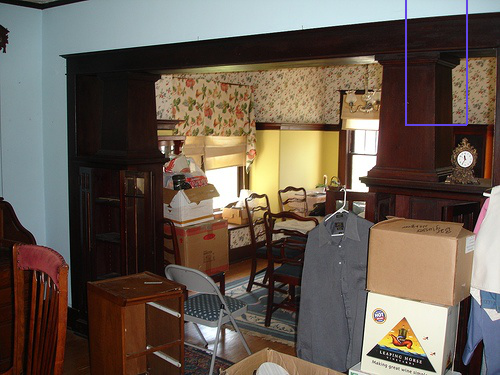

In [16]:
test_decode = decode_predictions(get_expected_output_from_annotations(testannotation),
                                 parsedannotation.imagewidth, parsedannotation.imageheight, 0.1)

for obj in test_decode:
    print(obj)

draw_image(testimage, test_decode)

(1, 224, 224, 3)


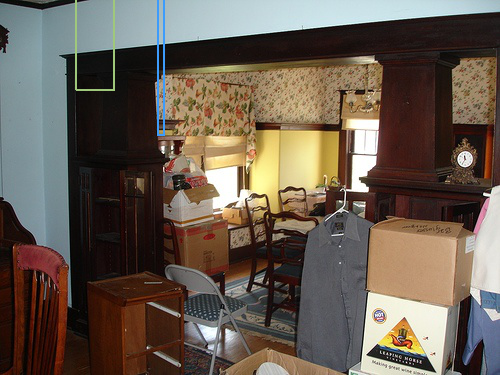

In [23]:
def image_to_nn_input(imagepath, inputshape):
    im = Img.open(imagepath).resize(inputshape)
    normalized = np.array(im) / 255
    
    return normalized
    
def feed_forward(imagepath, threshold = 0.3):
    im = Img.open(imagepath).resize((224, 224))
    
    normalized = np.array(im) / 255
    normalized = np.array([normalized])
    print(normalized.shape)
    
    out = model.predict(normalized)[0]
    
    
    decoded = decode_predictions(out, im.width, im.height, threshold)
    
    draw_image(imagepath, decoded)
    
feed_forward(testimage)

In [25]:
def train():
    imagesdir = r'.\\VOCdevkit\\VOC2007\\JPEGImages\\'
    annonsdir = r'.\\VOCdevkit\\VOC2007\\Annotations\\'
    
    
    ims = np.array([image_to_nn_input(imagesdir + parse_annotation(annotation).filename, (224, 224)) for annotation in files])
    outs = np.array([get_expected_output_from_annotations(file) for file in files])
    
    print(ims.shape)
    print(outs.shape)
    
    #model.fit(x = ims, y = outs, epochs = 100)
    
train()

(100, 224, 224, 3)
(100, 1470)


(1, 224, 224, 3)


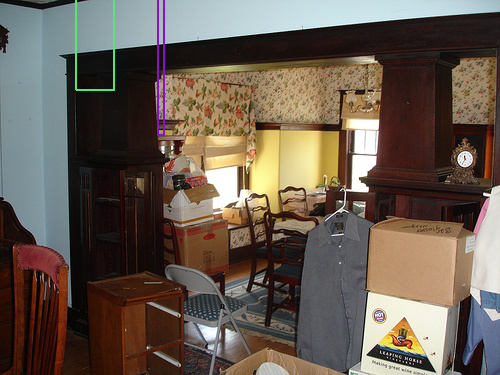

In [24]:
feed_forward(testimage)